In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import defaultdict
import math
import scipy.optimize
from sklearn import svm
import numpy
import string
import random
import string
from sklearn import linear_model
from nltk.corpus import stopwords
import nltk
from tqdm.auto import tqdm


warnings.filterwarnings('ignore')



In [2]:
# Read the data
df = pd.read_csv('analyst_ratings_processed.csv')
df.head()

,Unnamed: 0,title,date,stock
0,0.0,Stocks That Hit 52-Week Highs On Friday,2020-06-05 10:30:00-04:00,A
1,1.0,Stocks That Hit 52-Week Highs On Wednesday,2020-06-03 10:45:00-04:00,A
2,2.0,71 Biggest Movers From Friday,2020-05-26 04:30:00-04:00,A
3,3.0,46 Stocks Moving In Friday's Mid-Day Session,2020-05-22 12:45:00-04:00,A
4,4.0,B of A Securities Maintains Neutral on Agilent...,2020-05-22 11:38:00-04:00,A


In [3]:
len(df['title'].unique())

843225

In [4]:
dfd2 = pd.read_csv('us_equities_news_dataset.csv')
dfd2 = dfd2[['release_date','ticker', 'title']]
dfd2.columns = ['date', 'stock', 'title']
dfd2.head()

,date,stock,title
0,2020-01-15,NIO,Why Shares of Chinese Electric Car Maker NIO A...
1,2020-01-18,NIO,NIO only consumer gainer Workhorse Group amon...
2,2020-01-15,NIO,NIO leads consumer gainers Beyond Meat and Ma...
3,2020-01-15,NIO,NIO NVAX among premarket gainers
4,2020-01-06,NIO,PLUG NIO among premarket gainers


In [5]:
df = df.iloc[:,1:]

In [6]:
df['date'] = df['date'].apply(lambda x: x.split(' ')[0] if type(x) == str else 0)
df = df[df['date'] != 0]

In [7]:
df2 = pd.concat([df, dfd2], axis=0)
len(df2)

1620693

In [8]:
# group by date and ticker, merge title into a list
df2 = df2.groupby(['date','stock']).agg({'title': list}).reset_index()
df2 = df2[df2['title'].apply(lambda x: len(x) > 3)]
df2

,date,stock,title
23,2008-10-29,TGT,[UPDATE 1 German inflation slowdown raises ECB...
27,2008-10-30,TGT,[UPDATE 1 Polish president backpedals on euro ...
32,2008-10-31,TGT,[Italy Oct EU inflation eases as oil prices sl...
57,2008-11-10,TGT,[ANALYSIS China s 600 bln stimulus is dotted ...
59,2008-11-11,BAC,[UPDATE 4 Fed OKs American Express as bank hol...
...,...,...,...
931468,2020-06-11,T,[UPDATE: Feinseth Says 'You also have Comcast ...
931533,2020-06-11,VGK,"[Afternoon Market Stats in 5 Minutes, Morning ..."
931554,2020-06-11,WFC,"[Quicken Loans Plans To IPO: Report, PreMarket..."
931560,2020-06-11,WMT,"[Financials, Energy Among Worst-Hit Sectors In..."


In [9]:
alltickers = df2['stock'].unique()
len(alltickers)

3865

In [10]:
# join the title list into a string
df2['title'] = df2['title'].apply(lambda x: ' '.join(x))


In [11]:
# from pandas_datareader import data as wb

# stockHistory = defaultdict(pd.Series)
# for ticker in tqdm(alltickers):
#     try:
#         stockHistory[ticker] = wb.DataReader(ticker, data_source='yahoo', start='2009-7-27', end='2020-6-12')['Close']
#     except:
#         pass


In [12]:
# # save the stock history into a csv file
# for ticker in tqdm(stockHistory):
#     stockHistory[ticker].to_csv('stock_history/'+ticker+'.csv')

In [13]:
# save the dictionary into a pickle file
import pickle
# with open('stockHistory.pickle', 'wb') as handle:
#     pickle.dump(stockHistory, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('stockHistory.pickle', 'rb') as f:
    stockHistory = pickle.load(f)

In [14]:
df3 = df2[df2['stock'].isin(stockHistory.keys())]
df3

,date,stock,title
23,2008-10-29,TGT,UPDATE 1 German inflation slowdown raises ECB ...
27,2008-10-30,TGT,UPDATE 1 Polish president backpedals on euro a...
32,2008-10-31,TGT,Italy Oct EU inflation eases as oil prices sli...
57,2008-11-10,TGT,ANALYSIS China s 600 bln stimulus is dotted w...
59,2008-11-11,BAC,UPDATE 4 Fed OKs American Express as bank hold...
...,...,...,...
931468,2020-06-11,T,UPDATE: Feinseth Says 'You also have Comcast w...
931533,2020-06-11,VGK,Afternoon Market Stats in 5 Minutes Morning Ma...
931554,2020-06-11,WFC,Quicken Loans Plans To IPO: Report PreMarket P...
931560,2020-06-11,WMT,"Financials, Energy Among Worst-Hit Sectors In ..."


In [15]:
# for each row, get the stock price log return for the next day
def getReturn(row):
    ticker = row['stock']
    date = row['date']
    data = stockHistory[ticker]
    # locate index of the date
    try:
        index = data.index.get_loc(date)
        today = data.iloc[index]
        # get the next day's price
        nextday = data.iloc[index+1]

        # include commission fee and bid ask spread
        nextday = nextday * 0.998
        
        return math.log(nextday/today)
    except:
        return None


df3['return'] = df3.apply(getReturn, axis=1)
df3 = df3.dropna()
df3 = df3.reset_index(drop=True)
df3


,date,stock,title,return
0,2009-07-27,BA,US STOCKS Futures flat as Honeywell Aetna spa...,0.021628
1,2009-07-27,CDNS,VeriSilicon Delivers Chip Designs on Time and ...,0.012550
2,2009-07-27,HMC,GLOBAL MARKETS Bulls in control as Asia stocks...,-0.009636
3,2009-07-27,TGT,UPDATE 2 Hungary slashes rates by 100 bps sig...,0.006131
4,2009-07-28,CAJ,Canon Q2 profit tumbles lifts forecast slight...,-0.006172
...,...,...,...,...
56259,2020-06-11,T,UPDATE: Feinseth Says 'You also have Comcast w...,0.008877
56260,2020-06-11,VGK,Afternoon Market Stats in 5 Minutes Morning Ma...,0.016750
56261,2020-06-11,WFC,Quicken Loans Plans To IPO: Report PreMarket P...,0.041102
56262,2020-06-11,WMT,"Financials, Energy Among Worst-Hit Sectors In ...",-0.021765


In [16]:
df3['title'][0]

'US STOCKS Futures flat as Honeywell  Aetna spark caution US STOCKS Wall St to open flat as Honeywell  Aetna weigh US STOCKS Wall St drops as outlooks  profit taking weigh US STOCKS WAll St slips as weak results spur profit taking US STOCKS Wall St dips after rally  banks up on data'

In [17]:
# drop punctuation

punctuation = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', punctuation))

# drop digits and numbers and any words with digits
def remove_digits(text):
    return ''.join([i for i in text if not i.isdigit()])
def remove_numbers(text):
    return ''.join([i for i in text if not i.isnumeric()])
def remove_words_with_digits(text):
    return ' '.join([i for i in text.split() if not any(c.isdigit() for c in i)])

df3['title'] = df3['title'].apply(remove_punctuation)
df3['title'] = df3['title'].apply(remove_digits)
df3['title'] = df3['title'].apply(remove_numbers)
df3['title'] = df3['title'].apply(remove_words_with_digits)

# drop words with length less than 3 (neutral words: vs, q, ep, etc)
def remove_short_words(text):
    return ' '.join([i for i in text.split() if len(i) > 3])

df3['title'] = df3['title'].apply(remove_short_words)
df3['title'][0]

'STOCKS Futures flat Honeywell Aetna spark caution STOCKS Wall open flat Honeywell Aetna weigh STOCKS Wall drops outlooks profit taking weigh STOCKS WAll slips weak results spur profit taking STOCKS Wall dips after rally banks data'

In [18]:
# all lowercase
df3['title'] = df3['title'].apply(lambda x: x.lower())
df3['title'][0]

'stocks futures flat honeywell aetna spark caution stocks wall open flat honeywell aetna weigh stocks wall drops outlooks profit taking weigh stocks wall slips weak results spur profit taking stocks wall dips after rally banks data'

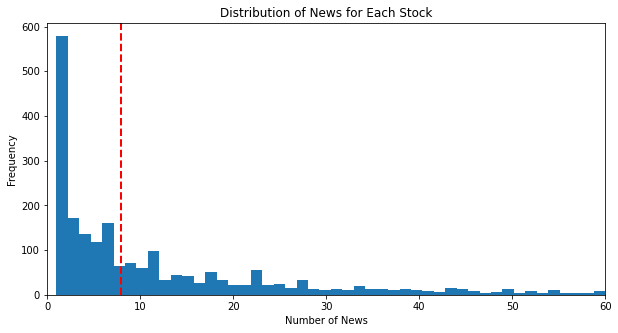

mean:  23.83058026260059
median:  8.0
std:  56.37218267643648


: 

In [71]:
# examine amounts of news for each stock

concentrate = df3.groupby('stock').count().sort_values('title', ascending=False)['title']
distribution = concentrate.describe()
mean = distribution['mean']
median = distribution['50%']

# plot the distribution of news for each stock
plt.figure(figsize=(10,5))
plt.xlim(0, 60)
plt.hist(concentrate, bins=1000)
plt.axvline(median, color='r', linestyle='dashed', linewidth=2, label='median')
plt.title('Distribution of News for Each Stock')
plt.xlabel('Number of News')
plt.ylabel('Frequency')
plt.show()

print('mean: ', mean)
print('median: ', concentrate.median())
print('std: ', concentrate.std())

In [20]:
stocksIndex = (concentrate > 10) == True
stocksIndex = stocksIndex[stocksIndex == True].index

df4 = df3[df3['stock'].isin(stocksIndex)]
df4

# everyday has >= 3 news and stocks that has more than 10 days of news, just to get rid of small companies and less volatile stocks

,date,stock,title,return
0,2009-07-27,BA,stocks futures flat honeywell aetna spark caut...,0.021628
1,2009-07-27,CDNS,verisilicon delivers chip designs time lower c...,0.012550
2,2009-07-27,HMC,global markets bulls control asia stocks exten...,-0.009636
3,2009-07-27,TGT,update hungary slashes rates signals more cuts...,0.006131
4,2009-07-28,CAJ,canon profit tumbles lifts forecast slightly u...,-0.006172
...,...,...,...,...
56258,2020-06-11,RIG,stocks moving thursdays midday session shares ...,0.087893
56259,2020-06-11,T,update feinseth says also have comcast which o...,0.008877
56261,2020-06-11,WFC,quicken loans plans report premarket prep stoc...,0.041102
56262,2020-06-11,WMT,financials energy among worsthit sectors bigge...,-0.021765


In [21]:
df4['label'] = df4['return'].apply(lambda x: 1 if x > 0 else 0)
df4

,date,stock,title,return,label
0,2009-07-27,BA,stocks futures flat honeywell aetna spark caut...,0.021628,1
1,2009-07-27,CDNS,verisilicon delivers chip designs time lower c...,0.012550,1
2,2009-07-27,HMC,global markets bulls control asia stocks exten...,-0.009636,0
3,2009-07-27,TGT,update hungary slashes rates signals more cuts...,0.006131,1
4,2009-07-28,CAJ,canon profit tumbles lifts forecast slightly u...,-0.006172,0
...,...,...,...,...,...
56258,2020-06-11,RIG,stocks moving thursdays midday session shares ...,0.087893,1
56259,2020-06-11,T,update feinseth says also have comcast which o...,0.008877,1
56261,2020-06-11,WFC,quicken loans plans report premarket prep stoc...,0.041102,1
56262,2020-06-11,WMT,financials energy among worsthit sectors bigge...,-0.021765,0


In [22]:

df4['title'] = df4['title'].apply(lambda x: x.replace('  ', ' '))

In [56]:
df4.head()

,date,stock,title,return,label
0,2009-07-27,BA,stocks futures flat honeywell aetna spark caut...,0.021628,1
1,2009-07-27,CDNS,verisilicon delivers chip designs time lower c...,0.012550,1
2,2009-07-27,HMC,global markets bulls control asia stocks exten...,-0.009636,0
3,2009-07-27,TGT,update hungary slashes rates signals more cuts...,0.006131,1
4,2009-07-28,CAJ,canon profit tumbles lifts forecast slightly u...,-0.006172,0


In [23]:
for i in range(5):
    print(df4['title'][i])

stocks futures flat honeywell aetna spark caution stocks wall open flat honeywell aetna weigh stocks wall drops outlooks profit taking weigh stocks wall slips weak results spur profit taking stocks wall dips after rally banks data
verisilicon delivers chip designs time lower cost with cadence incyte chip estimator cadence announces that stmicroelectronics adopts encounter signoff solutions designs from nanometers electronics adopts cadence conformal technology improved engineering design management faster time market cadence validates optimized libraries process
global markets bulls control asia stocks extend rally global markets world stocks month peak euro rallies global markets world stocks race fresh month peak europe shares resume uptrend month peak
update hungary slashes rates signals more cuts preview anglo stand alone strategy trump figures interview honeywell sees cost cuts paying update friends breaks resolution talks wrapup emerging struggles with worsening budget outlooks m

In [24]:
# Build dataset
# remove stop words

wordCount = defaultdict(int)

steamer = nltk.stem.porter.PorterStemmer()
stopwords = nltk.corpus.stopwords.words('english')

def feature(data):
    for index, row in tqdm(data.iterrows()):
        news = row['title']
        for word in news.split():
            word = steamer.stem(word)
            if word not in stopwords:
                wordCount[word] += 1
        
feature(df4)



50977it [00:32, 1588.01it/s]


In [25]:
# sort the word count dictionary

wordCount = sorted(wordCount.items(), key=lambda x: x[1], reverse=True)
topWords = [x[0] for x in wordCount[:2000]]
topWords[:10]

['stock',
 'market',
 'earn',
 'share',
 'updat',
 'report',
 'sale',
 'trade',
 'price',
 'lower']

In [28]:
# for each rows, make feature vector of the top 100 words for that news
# bag of words

def featureVector(row):
    news = row['title']
    vector = [0 for i in range(2000)]
    for word in news.split():
        if word in topWords:
            vector[topWords.index(word)] += 1
    return vector

xFeatures = [featureVector(row) for index, row in tqdm(df4.iterrows())]
yLabels = df4['label'].tolist()

50977it [00:42, 1198.81it/s]


In [29]:
from sklearn.model_selection import train_test_split
xTrain, xTest, yTrain, yTest = train_test_split(xFeatures, yLabels, test_size=0.2, random_state=42)

In [30]:
len(xTrain), len(xTest)

(40781, 10196)

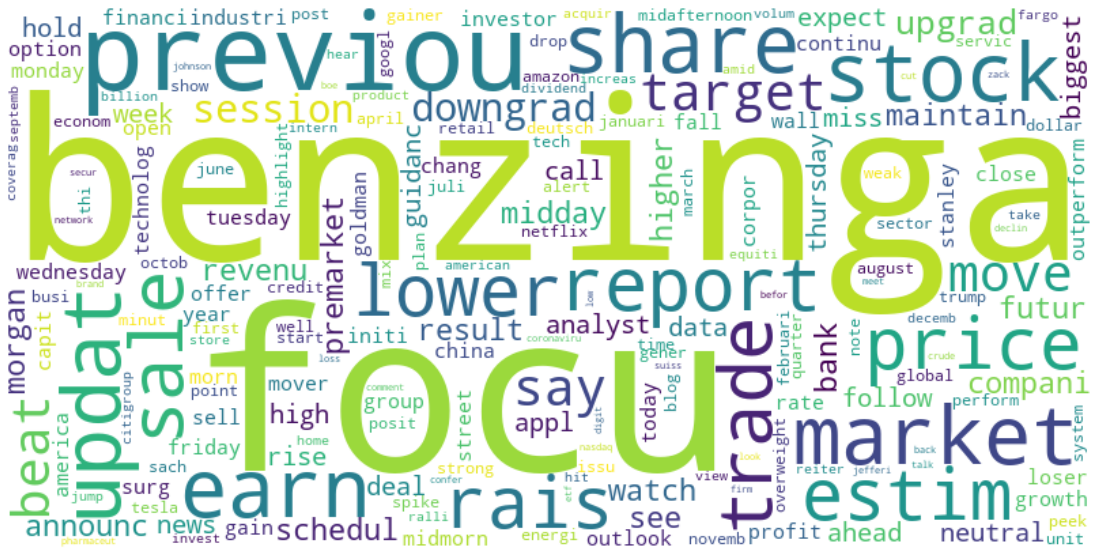

In [35]:
# plot topwords
# generate a word cloud image

from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=800, height=400, max_words=200, background_color="white").generate(' '.join(topWords))
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()



In [31]:
# Baseline model: Random Guessing
# find accuracy score on validation set

RandomGuess = []
for i in range(len(yTest)):
    RandomGuess.append(random.randint(0,1))

print('Random Guess: ', round(np.mean(
    [RandomGuess[i] == yTest[i] for i in range(len(yTest))]), 4))

# Baseline2 model: all 1
# find accuracy score on validation set

All1 = [1 for i in range(len(yTest))]
print('All 1: ', round(np.mean(
    [All1[i] == yTest[i] for i in range(len(yTest))]), 4))


# Baseline3 model: all 0
# find accuracy score on validation set

All0 = [0 for i in range(len(yTest))]
print('All 0: ', round(np.mean(
    [All0[i] == yTest[i] for i in range(len(yTest))]), 4))
    

Random Guess:  0.4943
All 1:  0.4589
All 0:  0.5411


In [354]:
# build a logistic regression model
# Bag of words Uni-gram


from sklearn.linear_model import LogisticRegression

logisticRegr = LogisticRegression()
logisticRegr.fit(xTrain, yTrain)

# find accuracy score on validation set
print('Accuracy score on validation set: ', logisticRegr.score(xTest, yTest))


Accuracy score on validation set:  0.5277559827383288


In [356]:
# build a multlayer perceptron model with keras

from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(512, activation='relu', input_dim=2000))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
                optimizer='rmsprop',
                metrics=['accuracy'])

# keep track of the validation accuracy and loss
# implement early stopping to prevent overfitting
# keep the best model that has highest validation accuracy

from keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=3, monitor='val_accuracy', mode='max',
                                        restore_best_weights=True)

history = model.fit(np.array(xTrain), np.array(yTrain),
                    batch_size=32,
                    epochs=100,
                    verbose=1,
                    validation_split=0.2,
                    callbacks=[early_stopping_monitor])

# find accuracy score on validation set
score = model.evaluate(np.array(xTest), np.array(yTest), verbose=0)
print('Accuracy score on validation set: ', score[1])



Epoch 1/100
1020/1020 [==============================] - 11s 10ms/step - loss: 0.6950 - accuracy: 0.5312 - val_loss: 0.6930 - val_accuracy: 0.5363
Epoch 2/100
1020/1020 [==============================] - 10s 10ms/step - loss: 0.6910 - accuracy: 0.5412 - val_loss: 0.6921 - val_accuracy: 0.5363
Epoch 3/100
1020/1020 [==============================] - 10s 10ms/step - loss: 0.6883 - accuracy: 0.5512 - val_loss: 0.6905 - val_accuracy: 0.5414
Epoch 4/100
1020/1020 [==============================] - 10s 10ms/step - loss: 0.6853 - accuracy: 0.5651 - val_loss: 0.6917 - val_accuracy: 0.5328
Epoch 5/100
1020/1020 [==============================] - 10s 10ms/step - loss: 0.6811 - accuracy: 0.5744 - val_loss: 0.6970 - val_accuracy: 0.5329
Epoch 6/100
1020/1020 [==============================] - 10s 9ms/step - loss: 0.6770 - accuracy: 0.5850 - val_loss: 0.7127 - val_accuracy: 0.5295
Accuracy score on validation set:  0.5459984540939331


In [360]:
# use bigram instead of unigram
# use package

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(2,2), max_features=2000)
xFeatures = vectorizer.fit_transform(df4['title']).toarray()
yLabels = df4['label'].tolist()

xTrain, xTest, yTrain, yTest = train_test_split(xFeatures, yLabels, test_size=0.2, random_state=42)

logisticRegr = LogisticRegression()
logisticRegr.fit(xTrain, yTrain)

# find accuracy score on validation set
print('Accuracy score on validation set: ', logisticRegr.score(xTest, yTest))


# Bigram doesn't improve the accuracy score a little bit




Accuracy score on validation set:  0.5231463318948607


In [362]:
# use tf-idf instead of bag of words
# unigram

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=2000)
xFeatures = vectorizer.fit_transform(df4['title']).toarray()
yLabels = df4['label'].tolist()

xTrain, xTest, yTrain, yTest = train_test_split(xFeatures, yLabels, test_size=0.2, random_state=42)

logisticRegr = LogisticRegression()
logisticRegr.fit(xTrain, yTrain)

# find accuracy score on validation set
print('Accuracy score on validation set: ', logisticRegr.score(xTest, yTest))

# improved from bag of words a little bit

Accuracy score on validation set:  0.5340329540996469


In [361]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=2000, ngram_range=(2,2))
xFeatures = vectorizer.fit_transform(df4['title']).toarray()
yLabels = df4['label'].tolist()

xTrain, xTest, yTrain, yTest = train_test_split(xFeatures, yLabels, test_size=0.2, random_state=42)

logisticRegr = LogisticRegression()
logisticRegr.fit(xTrain, yTrain)

# find accuracy score on validation set
print('Accuracy score on validation set: ', logisticRegr.score(xTest, yTest))

# doesn't improve from bag of words bigram, unigram tf-idf is better overall.
# But all worse than the keras model MLP

Accuracy score on validation set:  0.5224597881522166


# Try some LSTM with word mapping

##### Rebuild feature for LSTM: keep stopwords as it adds new information to the sentence. I am not doing sentiment analysis or categorizing, so removing stopwords is not necessary and may reduce level of syntactic information.

In [36]:
# tokenize the reviews
from collections import Counter

traindata = df4['title'].tolist()[:int(len(df4)*0.8)]
testdata = df4['title'].tolist()[int(len(df4)*0.8):]

Combined = ' '.join([review for review in traindata])
words = Combined.split()

words = [steamer.stem(word.lower()) for word in words]

countWords = Counter(words)
totalWords = len(words)
sortedWords = countWords.most_common(totalWords)

vocabToInt = {w: i+1 for i, (w, c) in enumerate(sortedWords)}


In [37]:
vocabToInt

{'stock': 1,
 'market': 2,
 'earn': 3,
 'updat': 4,
 'share': 5,
 'report': 6,
 'from': 7,
 'sale': 8,
 'benzinga': 9,
 'rais': 10,
 'say': 11,
 'downgrad': 12,
 'lower': 13,
 'trade': 14,
 'upgrad': 15,
 'with': 16,
 'see': 17,
 'beat': 18,
 'schedul': 19,
 'down': 20,
 'price': 21,
 'estim': 22,
 'after': 23,
 'premarket': 24,
 'move': 25,
 'revenu': 26,
 'midday': 27,
 'bank': 28,
 'watch': 29,
 'higher': 30,
 'target': 31,
 'session': 32,
 'maintain': 33,
 'futur': 34,
 'compani': 35,
 'announc': 36,
 'morgan': 37,
 'result': 38,
 'analyst': 39,
 'will': 40,
 'expect': 41,
 'ahead': 42,
 'news': 43,
 'rise': 44,
 'call': 45,
 'follow': 46,
 'hold': 47,
 'data': 48,
 'neutral': 49,
 'deal': 50,
 'guidanc': 51,
 'profit': 52,
 'appl': 53,
 'high': 54,
 'week': 55,
 'biggest': 56,
 'outlook': 57,
 'option': 58,
 'into': 59,
 'fall': 60,
 'growth': 61,
 'miss': 62,
 'over': 63,
 'industri': 64,
 'open': 65,
 'wednesday': 66,
 'morn': 67,
 'rate': 68,
 'thursday': 69,
 'year': 70,
 'los

In [38]:
newsIntTrain = []
for news in traindata:
    r = [vocabToInt[steamer.stem(w.lower())] for w in news.split()]
    newsIntTrain.append(r)
yTrainLstm = df4['label'][:int(len(df4)*0.8)].tolist()


newsIntTest = []
for news in testdata:
    temp = []
    for w in news.split():
        word = steamer.stem(w.lower())
        if word in vocabToInt:
            temp.append(vocabToInt[word])
        else:
            temp.append(len(vocabToInt)+1)
    newsIntTest.append(temp)
yTestLstm = df4['label'][int(len(df4)*0.8):].tolist()

newsLen = [len(x) for x in newsIntTrain]

Mean news length:  43.58436526813958
Std news length:  35.71411041214603


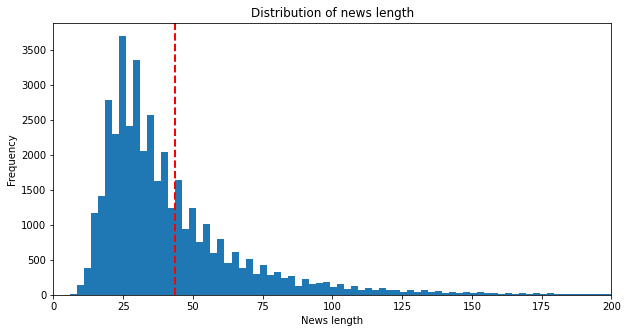

In [64]:


print('Mean news length: ', np.mean(newsLen))
print('Std news length: ', np.std(newsLen))

# plot the distribution of news length


plt.figure(figsize=(10, 5))
plt.xlim(0,200)
plt.hist(newsLen, bins=500)
plt.title('Distribution of news length')
plt.axvline(np.mean(newsLen), color='r', linestyle='dashed', linewidth=2)
plt.xlabel('News length')
plt.ylabel('Frequency')
plt.show()



In [45]:
# save the index of the data that has length less than 100 and greater than 5

index = [i for i, x in enumerate(newsLen) if x < 100 and x > 5]
len(index), index[-1]

(38824, 40780)

In [46]:
# remove the outliers
newsIntsWtO = [newsIntTrain[i] for i in index]
encodedLabelsWtO = [yTrainLstm[i] for i in index]
len(newsIntsWtO), len(encodedLabelsWtO)

(38824, 38824)

In [47]:
def padFeatures(newsInt, seqLength):

    features = numpy.zeros((len(newsInt), seqLength), dtype=int)

    for i, review in enumerate(newsInt):
        reviewLen = len(review)

        if reviewLen <= seqLength:
            zeroes = list(numpy.zeros(seqLength-reviewLen))
            new = zeroes+review
        elif reviewLen > seqLength:
            new = review[0:seqLength]

        features[i, :] = numpy.array(new)

    return features

In [48]:
seqLength = 100
featuresTrain = padFeatures(newsIntsWtO, seqLength=seqLength)
featuresTest = padFeatures(newsIntTest, seqLength=seqLength)


In [49]:
# find numbers of 1 and 0 in y

unique, counts = np.unique(encodedLabelsWtO, return_counts=True)
dict(zip(unique, counts))


{0: 21122, 1: 17702}

In [50]:
# cast y to numpy array in 2D

yTrainLstm = np.array(encodedLabelsWtO).reshape(-1,1)
yTestLstm = np.array(yTestLstm).reshape(-1,1)

In [51]:
len(featuresTrain), len(yTrainLstm), len(featuresTest), len(yTestLstm)

(38824, 38824, 10196, 10196)

In [37]:
# Add latent factor to the model
# use 3 latent factors: Positive, Negative, Neutral


In [38]:
### Users: reviews in string, Items: positive or negative, ratings: 1 or 0, latent factors: 3


In [39]:
# convert to regular list
yTrainLFM = yTrainLstm.tolist()
yTrainLFM = [x[0] for x in yTrainLFM]

In [ ]:
userIDs = {}
itemIDs = {}
interactions = []

for k in range(len(featuresTrain)):
    u = str(featuresTrain[k])
    i = 'positive' if yTrainLFM[k] == 1 else 'negative'
    r = yTrainLFM[k]
    if not u in userIDs:
        userIDs[u] = len(userIDs)
    if not i in itemIDs:
        itemIDs[i] = len(itemIDs)
    if r == 1:
        interactions.append((u, i, r))
        interactions.append((u, 'negative', 0))
    else:
        interactions.append((u, i, 1))
        interactions.append((u, 'positive', 0))





In [ ]:
random.shuffle(interactions)
len(interactions)

77648

In [ ]:
import tensorflow as tf


# mean return

mu = sum([r for _,_,r in interactions]) / len(interactions)
print(mu)
optimizer = tf.keras.optimizers.Adam(0.01)

0.5


In [83]:
class LatentFactorModel(tf.keras.Model):
    def __init__(self, mu, K, lamb):
        super(LatentFactorModel, self).__init__()
        # Initialize to average
        self.alpha = tf.Variable(mu)
        # Initialize to small random values
        self.betaU = tf.Variable(tf.random.normal([len(userIDs)],stddev=0.001))
        self.betaI = tf.Variable(tf.random.normal([len(itemIDs)],stddev=0.001))
        self.gammaU = tf.Variable(tf.random.normal([len(userIDs),K],stddev=0.001))
        self.gammaI = tf.Variable(tf.random.normal([len(itemIDs),K],stddev=0.001))
        self.lamb = lamb

    # Prediction for a single instance (useful for evaluation)
    def predict(self, u, i):
        p = self.alpha + self.betaU[u] + self.betaI[i] +\
            tf.tensordot(self.gammaU[u], self.gammaI[i], 1)
        return p

    # Regularizer
    def reg(self):
        return self.lamb * (tf.reduce_sum(self.betaU**2) +\
                            tf.reduce_sum(self.betaI**2) +\
                            tf.reduce_sum(self.gammaU**2) +\
                            tf.reduce_sum(self.gammaI**2))
    
    # Prediction for a sample of instances
    def predictSample(self, sampleU, sampleI):
        u = tf.convert_to_tensor(sampleU, dtype=tf.int32)
        i = tf.convert_to_tensor(sampleI, dtype=tf.int32)
        beta_u = tf.nn.embedding_lookup(self.betaU, u)
        beta_i = tf.nn.embedding_lookup(self.betaI, i)
        gamma_u = tf.nn.embedding_lookup(self.gammaU, u)
        gamma_i = tf.nn.embedding_lookup(self.gammaI, i)
        pred = self.alpha + beta_u + beta_i +\
               tf.reduce_sum(tf.multiply(gamma_u, gamma_i), 1)
        return pred
    
    # Loss
    def call(self, sampleU, sampleI, sampleR):
        pred = self.predictSample(sampleU, sampleI)
        r = tf.convert_to_tensor(sampleR, dtype=tf.float32)
        return tf.nn.l2_loss(pred - r) / len(sampleR)

In [84]:
modelLFM = LatentFactorModel(mu, 3, 0.00001)

In [85]:
def trainingStep(model, interactions):
    Nsamples = 70000
    with tf.GradientTape() as tape:
        sampleU, sampleI, sampleR = [], [], []
        for _ in range(Nsamples):
            u,i,r = random.choice(interactions)
            sampleU.append(userIDs[u])
            sampleI.append(itemIDs[i])
            sampleR.append(r)
        loss = model(sampleU,sampleI,sampleR)
        loss += model.reg()
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients((grad, var) for
                              (grad, var) in zip(gradients, model.trainable_variables)
                              if grad is not None)
    return loss.numpy()

In [86]:
for i in range(100):
    obj = trainingStep(modelLFM, interactions)
    if (i % 10 == 9): print("iteration " + str(i+1) + ", objective = " + str(obj))

iteration 10, objective = 0.12442562
iteration 20, objective = 0.118881755
iteration 30, objective = 0.102648094
iteration 40, objective = 0.07973423
iteration 50, objective = 0.060773913
iteration 60, objective = 0.048684075
iteration 70, objective = 0.03986988
iteration 80, objective = 0.034281448
iteration 90, objective = 0.03033993
iteration 100, objective = 0.027317949


In [40]:
def Jaccard(i1, i2):
    return len(i1.intersection(i2)) / len(i1.union(i2))
def accuracy(y, yhat):
    return sum([1 if y[i] == yhat[i] else 0 for i in range(len(y))]) / len(y)

In [41]:
yTestLFM = yTestLstm.tolist()
yTestLFM = [x[0] for x in yTestLFM]

In [ ]:

users = []
items = []
for k in tqdm(range(len(featuresTest))):
    similarities = []
    for x2 in featuresTrain:
        similarities.append(Jaccard(set(featuresTest[k]), set(x2)))
    useridx = np.argmax(similarities)
    u = userIDs[str(featuresTrain[useridx])]
    i = itemIDs['positive' if yTestLFM[k] == 1 else 'negative']
    users.append(u)
    items.append(i)
predicLFM = modelLFM.predictSample(users, items)




100%|██████████| 10196/10196 [1:28:42<00:00,  1.92it/s]


In [103]:
# with open("predicLFM", "wb") as fp:   #Pickling
#     pickle.dump(predicLFM, fp)
with open("predicLFM", "rb") as fp:   # Unpickling
    predicLFM = pickle.load(fp)

In [112]:

usersTrain = []
itemsTrain = []
for u, i, r in tqdm(interactions):
    user = userIDs[u]
    item = itemIDs[i]
    usersTrain.append(user)
    itemsTrain.append(item)

predicTrainLFM = modelLFM.predictSample(usersTrain, itemsTrain)
    

100%|██████████| 77648/77648 [00:00<00:00, 964587.06it/s]


In [118]:
# take every even index
predicTrainLFM = predicTrainLFM[::2]

In [119]:
# with open("predicTrainLFM", "wb") as fp:   #Pickling
#     pickle.dump(predicTrainLFM, fp)

In [102]:
with open("predicTrainLFM", "rb") as fp:   # Unpickling
    predicTrainLFM = pickle.load(fp)

In [44]:
# reverse featureTrain to words and use bag of words

selectedX = []
selectedY = encodedLabelsWtO
for i in tqdm(range(len(traindata))):
    if i in index:
        selectedX.append([steamer.stem(word) for word in traindata[i].split()])

len(selectedX), len(selectedY)
       

100%|██████████| 40781/40781 [00:22<00:00, 1820.18it/s]


(38824, 38824)

35698

In [142]:
def featureBagOfWords(datum):
    vector = [0 for i in range(2000)]
    for word in datum:
        if word in topWords:
            vector[topWords.index(word)] += 1
    return vector

selectedXFeatures = [featureBagOfWords(datum) for datum in selectedX]




In [143]:
len(selectedXFeatures), len(selectedY)

(38824, 38824)

In [66]:
len(selectedXFeatures), len(selectedY), len(predicTrainLFM)

(38824, 38824, 38824)

In [81]:
# process validation data

# return index of news length > 5, < 100
index_test = []
for i in range(len(testdata)):
    if len(testdata[i].split()) > 5 and len(testdata[i].split()) < 100:
        index_test.append(i)

selectedXTest = [testdata[i] for i in index_test]


In [145]:
selectedXTestFeatures = [featureBagOfWords(datum) for datum in selectedXTest]

In [55]:
yTestLstm.tolist()
yTestLstm = [yTestLstm[i][0] for i in index_test]

In [151]:
selectedXFeatures = np.array(selectedXFeatures)
selectedY = np.array(selectedY)
predicTrainLFM = np.array(predicTrainLFM)
selectedXTestFeatures = np.array(selectedXTestFeatures)
yTestLstm = np.array(yTestLstm)
predicLFM = np.array(predicLFM)

selectedXFeatures.shape, selectedY.shape, predicTrainLFM.shape, selectedXTestFeatures.shape, yTestLstm.shape, predicLFM.shape



((38824, 2000), (38824,), (38824,), (9233, 2000), (9233,), (9233,))

In [152]:
# combine LFM and selectedXFeatures

combinedTrainBag = np.concatenate((selectedXFeatures, predicTrainLFM.reshape(-1,1)), axis=1)
combinedTestBag = np.concatenate((selectedXTestFeatures, predicLFM.reshape(-1,1)), axis=1)



Epoch 1/20
971/971 [==============================] - 10s 10ms/step - loss: 0.7892 - accuracy: 0.5370 - val_loss: 0.6905 - val_accuracy: 0.5375
Epoch 2/20
971/971 [==============================] - 9s 9ms/step - loss: 0.6917 - accuracy: 0.5452 - val_loss: 0.6903 - val_accuracy: 0.5375
Epoch 3/20
971/971 [==============================] - 9s 9ms/step - loss: 0.6907 - accuracy: 0.5452 - val_loss: 0.6905 - val_accuracy: 0.5375
Epoch 4/20
971/971 [==============================] - 9s 9ms/step - loss: 0.6932 - accuracy: 0.5450 - val_loss: 0.6909 - val_accuracy: 0.5375
Epoch 5/20
971/971 [==============================] - 9s 10ms/step - loss: 0.6916 - accuracy: 0.5449 - val_loss: 0.6907 - val_accuracy: 0.5375
Epoch 6/20
971/971 [==============================] - 9s 10ms/step - loss: 0.6908 - accuracy: 0.5450 - val_loss: 0.6910 - val_accuracy: 0.5375
Epoch 7/20
971/971 [==============================] - 9s 10ms/step - loss: 0.6926 - accuracy: 0.5447 - val_loss: 0.6914 - val_accuracy: 0.5375
A

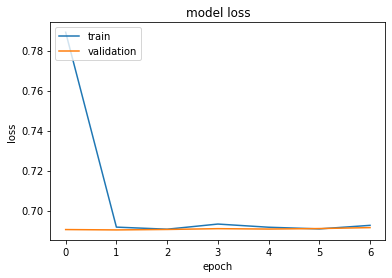

In [153]:
# build a multlayer perceptron model with keras

from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(512, activation='relu', input_dim=2001))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
                optimizer='rmsprop',
                metrics=['accuracy'])

# keep track of the validation accuracy and loss
# implement early stopping to prevent overfitting
# keep the best model that has highest validation accuracy

from keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=5, monitor='val_loss', mode='min',
                                        restore_best_weights=True)

history = model.fit(combinedTrainBag, selectedY,
                    batch_size=32,
                    epochs=20,
                    verbose=1,
                    validation_split=0.2,
                    callbacks=[early_stopping_monitor])

# find accuracy score on validation set
score = model.evaluate(combinedTestBag, yTestLstm, verbose=0)
print('Accuracy score on validation set: ', score[1])

# plot the training and validation loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [129]:
# use tfidf to vectorize

from sklearn.feature_extraction.text import TfidfVectorizer

xTfidf = [' '.join(x) for x in selectedX]
vectorizer = TfidfVectorizer(max_features=2000)
X = vectorizer.fit_transform(xTfidf)
X = X.toarray()


In [133]:
xTestTfidf = [' '.join(x) for x in selectedXTest]
XTest = vectorizer.transform(xTestTfidf)
XTest = XTest.toarray()


In [134]:
# combine with LFM features

combinedTrain = np.concatenate((X, np.array(predicTrainLFM).reshape(-1,1)), axis=1)
combinedTest = np.concatenate((XTest, np.array(predicLFM).reshape(-1,1)), axis=1)

combinedTrain.shape, combinedTest.shape

((38824, 2001), (9233, 2001))

Epoch 1/20
971/971 [==============================] - 10s 10ms/step - loss: 0.8455 - accuracy: 0.5343 - val_loss: 0.6906 - val_accuracy: 0.5375
Epoch 2/20
971/971 [==============================] - 9s 10ms/step - loss: 0.6943 - accuracy: 0.5444 - val_loss: 0.6904 - val_accuracy: 0.5375
Epoch 3/20
971/971 [==============================] - 9s 9ms/step - loss: 0.6903 - accuracy: 0.5452 - val_loss: 0.6905 - val_accuracy: 0.5375
Epoch 4/20
971/971 [==============================] - 9s 10ms/step - loss: 0.6904 - accuracy: 0.5458 - val_loss: 0.6905 - val_accuracy: 0.5375
Epoch 5/20
971/971 [==============================] - 12s 12ms/step - loss: 0.6909 - accuracy: 0.5453 - val_loss: 0.6905 - val_accuracy: 0.5375
Epoch 6/20
971/971 [==============================] - 12s 12ms/step - loss: 0.6899 - accuracy: 0.5452 - val_loss: 0.6909 - val_accuracy: 0.5375
Epoch 7/20
971/971 [==============================] - 13s 13ms/step - loss: 0.6909 - accuracy: 0.5451 - val_loss: 0.6906 - val_accuracy: 0.5

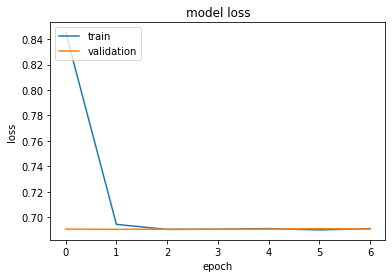

In [154]:
# build a multlayer perceptron model with keras tfidf

from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(512, activation='relu', input_dim=2001))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
                optimizer='rmsprop',
                metrics=['accuracy'])

# keep track of the validation accuracy and loss
# implement early stopping to prevent overfitting
# keep the best model that has highest validation accuracy

from keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=5, monitor='val_loss', mode='min',
                                        restore_best_weights=True)

history = model.fit(combinedTrain, selectedY,
                    batch_size=32,
                    epochs=20,
                    verbose=1,
                    validation_split=0.2,
                    callbacks=[early_stopping_monitor])

# find accuracy score on validation set
score = model.evaluate(combinedTest, yTestLstm, verbose=0)
print('Accuracy score on validation set: ', score[1])

# plot the losses

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [54]:
from keras.callbacks import EarlyStopping
from keras.layers import SpatialDropout1D
from keras.layers.embeddings import Embedding
from keras.layers import Dense, LSTM, Embedding
from keras.models import Sequential

# import dropout
from keras.layers import Dropout

model = Sequential()
model.add(Embedding(len(vocabToInt), 150, input_length=featuresTrain.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(1024, dropout=0.2, activation='tanh', recurrent_activation='sigmoid',
               recurrent_dropout=0, unroll=False, use_bias=True))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


epochs = 10
batch_size = 256


# add early stopping on validation accuracy
early = EarlyStopping(
    monitor="val_loss", mode="min", patience=3, verbose=1, restore_best_weights=True)

history = model.fit(featuresTrain, encodedLabelsWtO, epochs=epochs, batch_size=batch_size, validation_data=(
    featuresTest, yTestLstm), verbose=1, callbacks=[early])


# accuracy on validation set
score, acc = model.evaluate(featuresTest, yTestLstm, batch_size=batch_size)
print('Test accuracy:', acc)

# plot the losses

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()



ValueError: Failed to find data adapter that can handle input: <class 'numpy.ndarray'>, (<class 'list'> containing values of types {"<class 'int'>"})